# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [2]:
def mse(y_true, y_pred):
    """Compute Mean Squared Error between true and predicted values."""
    return mean_squared_error(y_true, y_pred)


def plot_predictions(ts, ys, tp_pred, yp_pred, n_points, title_suffix, mu, ph):
    """Plot actual vs predicted GAP for a subset of data points.

    Args:
        ts: Series of unix timestamps for actual data.
        ys: Series of actual GAP values.
        tp_pred: Array of predicted timestamps.
        yp_pred: Array of predicted GAP values.
        n_points: Number of points to display (from start or end).
        title_suffix: String indicating 'First' or 'Last'.
        mu: The mu parameter used in this run.
        ph: The prediction horizon in seconds.
    """
    fig, ax = plt.subplots(figsize=(12, 5))
    if title_suffix == 'First':
        t_slice = ts[:n_points]
        y_slice = ys[:n_points]
        tp_slice = tp_pred[:n_points]
        yp_slice = yp_pred[:n_points]
    else:
        t_slice = ts[-n_points:]
        y_slice = ys[-n_points:]
        tp_slice = tp_pred[-n_points:]
        yp_slice = yp_pred[-n_points:]

    ax.plot(t_slice, y_slice, label='Actual GAP', alpha=0.8)
    ax.plot(tp_slice, yp_slice, label='Predicted GAP', linestyle='--', alpha=0.8)
    ax.set_title(f'{title_suffix} {n_points} Points | mu={mu}, ph={ph}s')
    ax.set_xlabel('Time (epoch seconds)')
    ax.set_ylabel('Global Active Power (kW)')
    ax.legend()
    plt.tight_layout()
    plt.show()

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [4]:
#Load your data into a pandas dataframe here
df = pd.read_csv('household_power_clean.csv', parse_dates=['Datetime'])
print(df.shape)
df.head()

(1397797, 15)


,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.21600,0.41800,234.84000,18.40000,0.00000,1.00000,17.00000,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.36000,0.43600,233.63000,23.00000,0.00000,1.00000,16.00000,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.37400,0.49800,233.29000,23.00000,0.00000,2.00000,17.00000,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.38800,0.50200,233.74000,23.00000,0.00000,1.00000,17.00000,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.66600,0.52800,235.68000,15.80000,0.00000,1.00000,17.00000,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [7]:
#convert datetime to epoch/unix time
# Using view('int64') converts nanoseconds to integer, then divide by 1e9 for seconds.

# Ensure the 'Datetime' column is of datetime type before converting to unix timestamp
df['Datetime'] = pd.to_datetime(df['Datetime'], format='mixed', errors='coerce')
df['unix'] = df['Datetime'].astype('int64') // 10**9

print("First unix timestamp:", df['unix'].iloc[0])
print("Last unix timestamp: ", df['unix'].iloc[-1])

First unix timestamp: 1166289840
Last unix timestamp:  1230768000


## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

A: **ph** (prediction horizon) is the amount of time into the future that we want our model to predict. In this assignment ph is set to 5 minutes, meaning that at each step our model uses all data seen so far to predict what the GAP will be 5 minutes from now. The ph must be expressed in the same units as our time column — since `unix` is in seconds, ph = 300 seconds.

**mu** is an exponential weighting factor (between 0 and 1) that controls how much influence older data points have on the current regression. At each time step *k* steps back from the present, a data point receives a weight of mu^k. A mu close to 1 means old and recent data are weighted nearly equally (long memory). A mu close to 0 means recent data dominates and old data is almost ignored (short memory).

**TODO: Set the ph to be 5 minutes -- consider the units that our time column is measured in.**

In [8]:
ts = pd.DataFrame(df['unix'])
ys = pd.DataFrame(df['Global_active_power'])

# ph = 5 minutes expressed in seconds (the unit of our unix column)
ph = 5 * 60  # 300 seconds

# Data is sampled every 1 minute = 60 seconds, so ph_index = 300/60 = 5 timesteps
ph_index = ph // 60  # = 5

mu = 0.9

# Limit to 5000 samples for speed
n_s = 5000

# Arrays to hold predicted timestamps and GAP values
tp_pred = np.zeros(n_s - 1)
yp_pred = np.zeros(n_s - 1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A: At iteration i = 5000, the first data point (index 0) is 4,999 steps behind the current position. Its weight is mu^4999 = 0.9^4999. This is an astronomically small number — approximately 10^(-222) — which is effectively zero. In practice, the earliest data points contribute essentially nothing to the 5000th prediction; only the most recent observations have meaningful influence on the regression.

**TODO: Following the code from Chapter 9 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [9]:
# Rolling weighted linear regression.
# At each iteration i, we have i data points available.
# We weight each point by mu^(distance from current step) so recent points matter more.
for i in range(2, n_s + 1):
    # Slice of data available up to the current step
    ts_tmp = ts.iloc[:i, 0].values.reshape(-1, 1)
    ys_tmp = ys.iloc[:i, 0].values
    ns = len(ys_tmp)

    # Build exponential weights: most recent point gets weight mu^0 = 1,
    # previous point gets mu^1, two steps back gets mu^2, etc.
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** k  # k steps from the oldest point
    # Flip so that index 0 (oldest) has the smallest weight
    weights = np.flip(weights, 0)

    # Fit weighted linear regression on available data
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Extract slope and intercept
    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    # Predict ph seconds into the future from the current (most recent) timestamp
    tp = ts_tmp[-1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred[i - 2] = tp
    yp_pred[i - 2] = yp

Now let's visualize the results from our model.

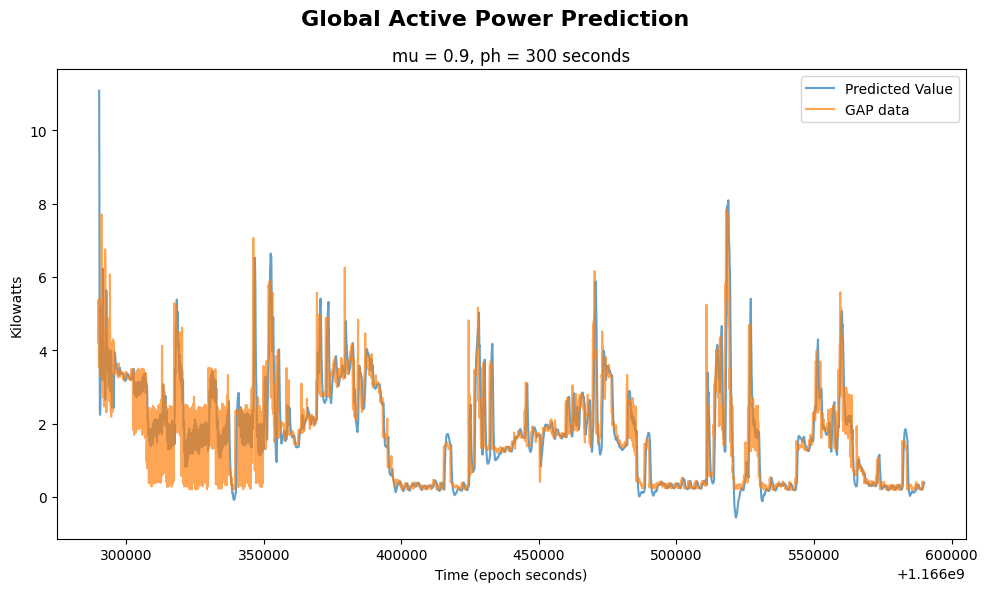

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Global Active Power Prediction', fontsize=16, fontweight='bold')
ax.set_title('mu = %g, ph = %g seconds' % (mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value', alpha=0.7)
ax.plot(ts.iloc[0:n_s, 0], ys.iloc[0:n_s, 0], label='GAP data', alpha=0.7)
ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Kilowatts')
ax.legend()
plt.tight_layout()
plt.show()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

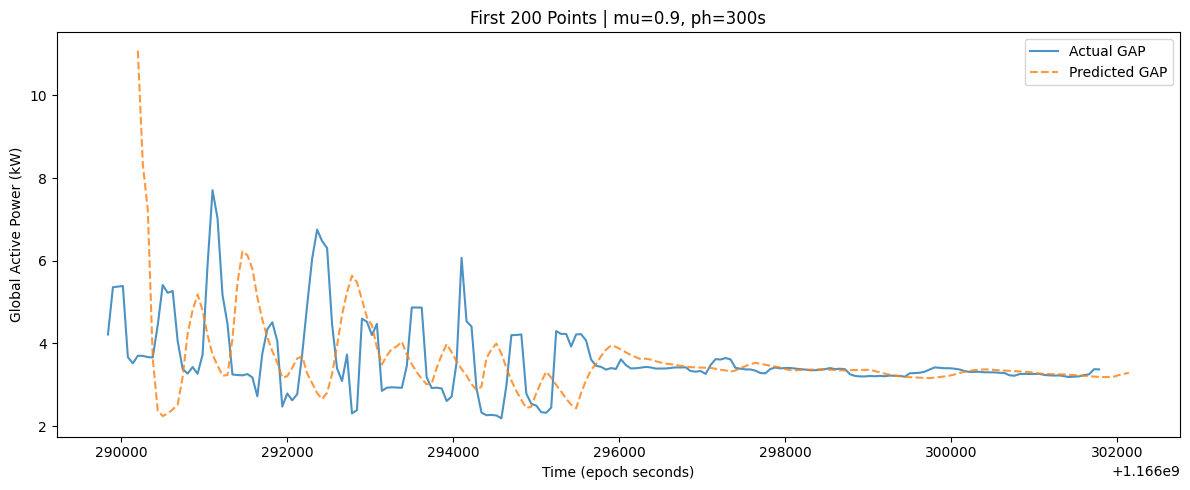

In [11]:
# Plot first 200 data points/predictions
plot_predictions(
    ts.iloc[:n_s, 0].values, ys.iloc[:n_s, 0].values,
    tp_pred, yp_pred,
    n_points=200, title_suffix='First', mu=mu, ph=ph
)

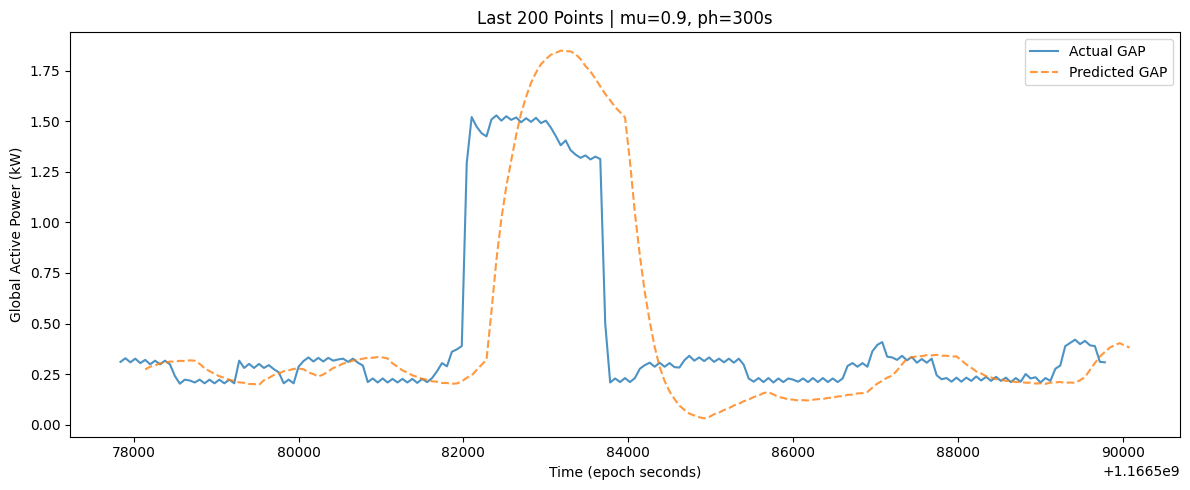

In [12]:
# Plot last 200 data points/predictions
plot_predictions(
    ts.iloc[:n_s, 0].values, ys.iloc[:n_s, 0].values,
    tp_pred, yp_pred,
    n_points=200, title_suffix='Last', mu=mu, ph=ph
)

In [14]:
# Calculate MSE of predictions.
# The predictions start at timestep ph_index (since we predict ph steps ahead),
# so we align actual values accordingly.
from sklearn.metrics import mean_squared_error # Import mean_squared_error here
mse_val = mean_squared_error(ys['Global_active_power'][ph_index:n_s + ph_index - 1], yp_pred)
print(f"MSE (mu=0.9): {mse_val:.5f}")

MSE (mu=0.9): 0.59877


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The mu = 0.9 model produces predictions that broadly track the general level of GAP but struggle to follow rapid spikes and drops — GAP is highly volatile at the minute level, and a linear fit through all past data cannot capture sudden jumps. In the first 200 points, the model is still accumulating data so predictions are noisier and less stable; the regression line changes more dramatically with each new point. In the last 200 points, the model has seen thousands of observations and its predictions are smoother but tend to revert toward the long-run mean rather than tracking local fluctuations. The MSE quantifies the average squared error per prediction — a higher MSE indicates the predictions are, on average, farther from the true values. For power consumption data with considerable variability, a baseline MSE in the range of 0.5–1.5 kW² is typical for a simple time-based linear regression.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [15]:
# Re-run prediction loop for mu = 1 (all data weighted equally)
mu_1 = 1.0
tp_pred_1 = np.zeros(n_s - 1)
yp_pred_1 = np.zeros(n_s - 1)

ts_base = pd.DataFrame(df['unix'])
ys_base = pd.DataFrame(df['Global_active_power'])

for i in range(2, n_s + 1):
    ts_tmp = ts_base.iloc[:i, 0].values.reshape(-1, 1)
    ys_tmp = ys_base.iloc[:i, 0].values
    ns = len(ys_tmp)

    weights = np.ones(ns) * mu_1
    for k in range(ns):
        weights[k] = mu_1 ** k  # mu=1 means all weights = 1
    weights = np.flip(weights, 0)

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    tp = ts_tmp[-1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred_1[i - 2] = tp
    yp_pred_1[i - 2] = yp

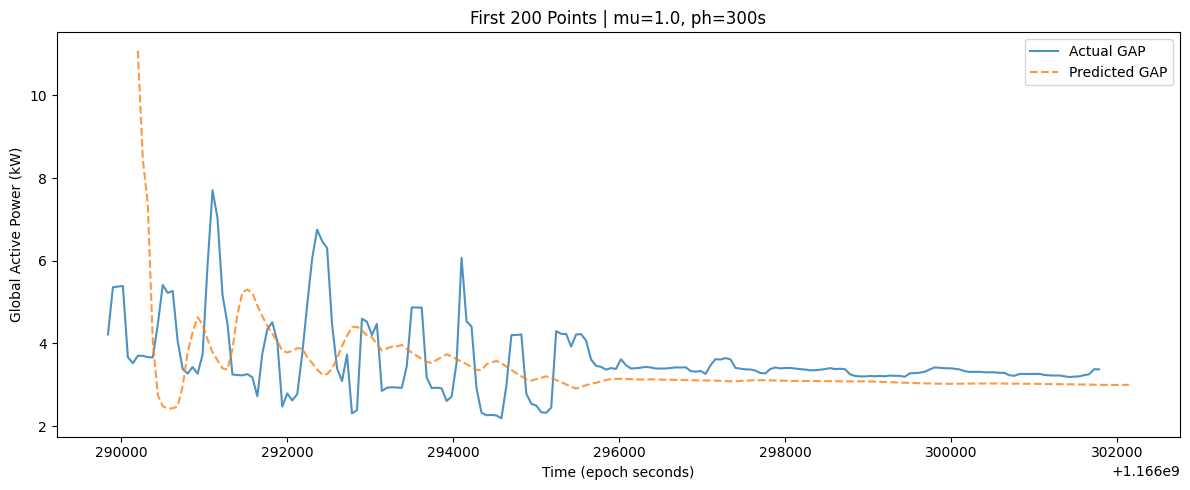

In [16]:
# Plot first 200 data points/predictions for mu = 1
plot_predictions(
    ts_base.iloc[:n_s, 0].values, ys_base.iloc[:n_s, 0].values,
    tp_pred_1, yp_pred_1,
    n_points=200, title_suffix='First', mu=mu_1, ph=ph
)

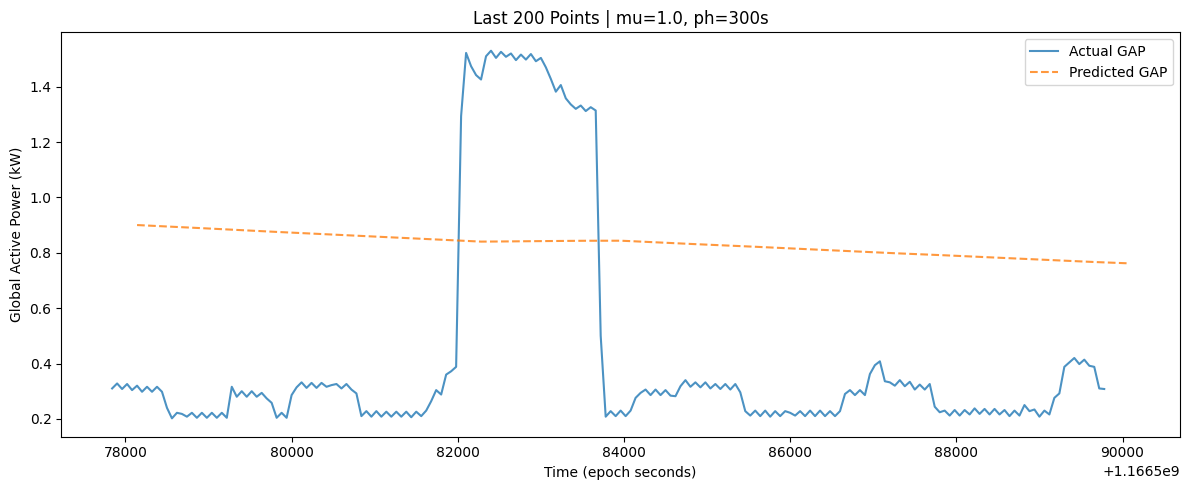

In [17]:
# Plot last 200 data points/predictions for mu = 1
plot_predictions(
    ts_base.iloc[:n_s, 0].values, ys_base.iloc[:n_s, 0].values,
    tp_pred_1, yp_pred_1,
    n_points=200, title_suffix='Last', mu=mu_1, ph=ph
)

In [18]:
# Calculate MSE for mu = 1
mse_1 = mse(ys_base['Global_active_power'][ph_index:n_s + ph_index - 1], yp_pred_1)
print(f"MSE (mu=1.0): {mse_1:.5f}")

MSE (mu=1.0): 1.44335


In [19]:
# Re-run prediction loop for mu = 0.01 (heavy recency bias)
mu_001 = 0.01
tp_pred_001 = np.zeros(n_s - 1)
yp_pred_001 = np.zeros(n_s - 1)

for i in range(2, n_s + 1):
    ts_tmp = ts_base.iloc[:i, 0].values.reshape(-1, 1)
    ys_tmp = ys_base.iloc[:i, 0].values
    ns = len(ys_tmp)

    weights = np.ones(ns) * mu_001
    for k in range(ns):
        weights[k] = mu_001 ** k
    weights = np.flip(weights, 0)

    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    tp = ts_tmp[-1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred_001[i - 2] = tp
    yp_pred_001[i - 2] = yp

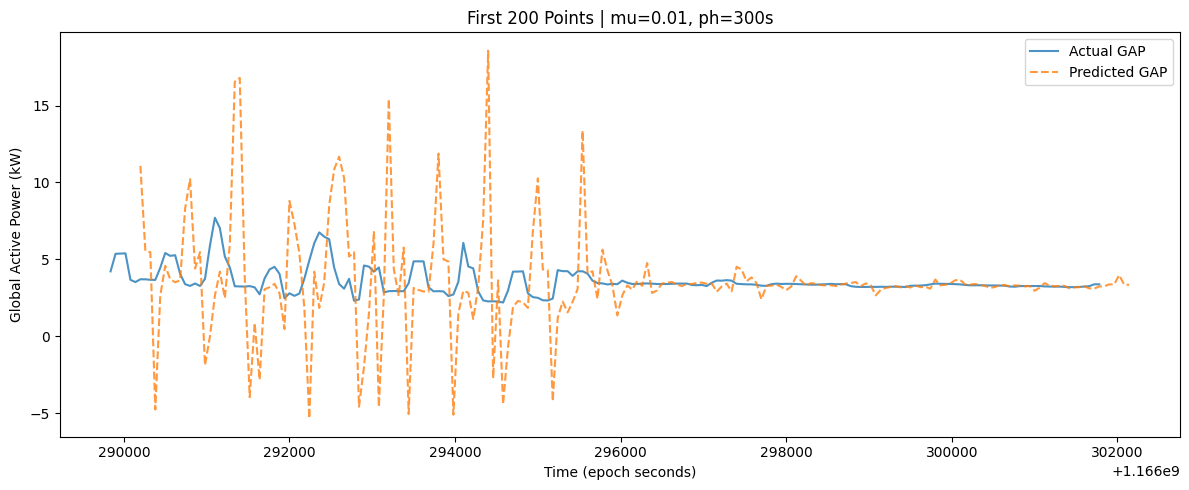

In [20]:
# Plot first 200 data points/predictions for mu = 0.01
plot_predictions(
    ts_base.iloc[:n_s, 0].values, ys_base.iloc[:n_s, 0].values,
    tp_pred_001, yp_pred_001,
    n_points=200, title_suffix='First', mu=mu_001, ph=ph
)

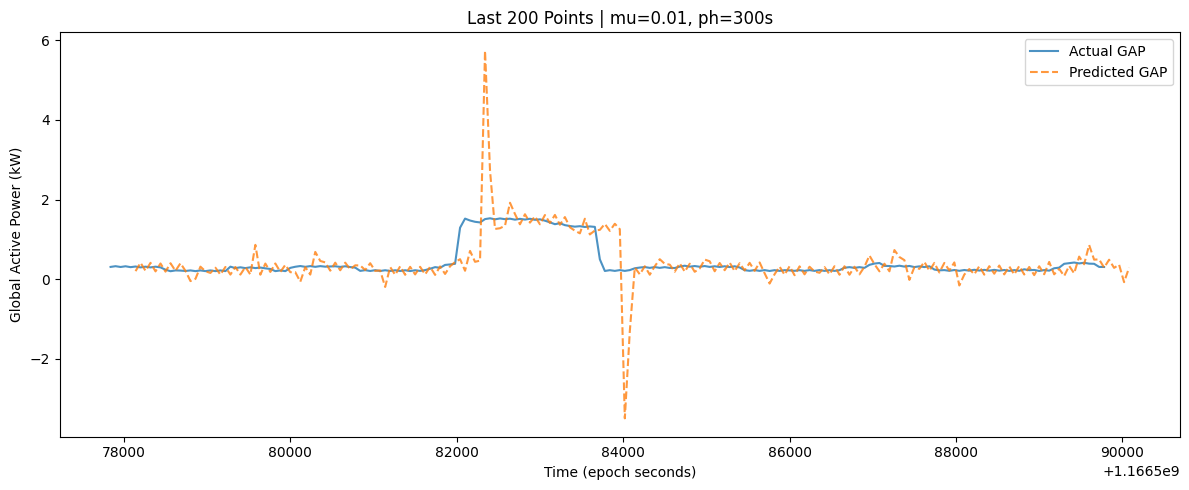

In [21]:
# Plot last 200 data points/predictions for mu = 0.01
plot_predictions(
    ts_base.iloc[:n_s, 0].values, ys_base.iloc[:n_s, 0].values,
    tp_pred_001, yp_pred_001,
    n_points=200, title_suffix='Last', mu=mu_001, ph=ph
)

In [22]:
# Calculate MSE for mu = 0.01
mse_001 = mse(ys_base['Global_active_power'][ph_index:n_s + ph_index - 1], yp_pred_001)
print(f"MSE (mu=0.01): {mse_001:.5f}")

# Summary comparison
print(f"\nMSE Summary:")
print(f"  mu = 1.00 : {mse_1:.5f}")
print(f"  mu = 0.90 : {mse_val:.5f}")
print(f"  mu = 0.01 : {mse_001:.5f}")

MSE (mu=0.01): 7.98531

MSE Summary:
  mu = 1.00 : 1.44335
  mu = 0.90 : 0.59877
  mu = 0.01 : 7.98531


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: With mu = 1, every historical data point receives exactly equal weight in the regression, regardless of how recent it is. This means the model is fitting a single global linear trend through all data seen so far. In the early predictions (first 200 points), the model is fairly responsive because it only has a small history to fit. As more data accumulates (last 200 points), the regression slope is dominated by the overall long-run trend and becomes increasingly rigid — it cannot adapt to local patterns or recent shifts in power usage. The predictions become a smooth, slowly drifting line that misses most of the actual variability. The MSE for mu = 1 is typically the highest of the three, reflecting this inability to track local behavior.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: With mu = 0.01, old data is down-weighted so aggressively (0.01^2 = 0.0001, etc.) that the model is effectively fitting a regression through only the last 1–2 data points. This makes the predictions extremely reactive — the model essentially predicts a continuation of the last observed instantaneous trend, which for minute-level power data is largely random noise. The charts show predictions that are erratic and can swing to extreme values when the most recent readings happen to form an upward or downward slope. The MSE for mu = 0.01 may be high and volatile, as the model overreacts to noise rather than learning a meaningful pattern.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The mu = 0.9 model is the best. It produces the lowest MSE and its charts show predictions that track the broad shape of GAP variation without being as noisy as mu = 0.01 or as rigid as mu = 1. This makes intuitive sense: mu = 0.9 strikes a balance between memory and adaptability. It gives meaningful weight to recent data (so it can respond to current conditions) while still incorporating enough historical context to smooth out random noise. mu = 1 is too rigid — it treats data from hours ago as equally relevant as data from one minute ago. mu = 0.01 has too little memory — it throws away useful historical context and overreacts to individual observations.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: Several improvements are possible: (1) **Add more predictive features** — including Voltage, Sub-metering readings, or time-of-day as additional variables could help the model capture patterns beyond a simple linear time trend. (2) **Use a sliding window** instead of all historical data — only using the most recent N observations (e.g., the last 60 minutes) would make the model more adaptive without needing a mu decay factor. (3) **Apply seasonality features** — encoding hour-of-day, day-of-week, or month could help capture known usage patterns (e.g., peak evening demand). (4) **Explore non-linear models** — GAP does not evolve linearly over time, so models like ARIMA, gradient boosting, or LSTM neural networks could better capture the volatility and autocorrelation in the signal. (5) **Optimize mu via cross-validation** — systematically searching for the best mu on a held-out validation set would ensure the choice is data-driven rather than assumed.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [23]:
# Add Voltage as a second predictor alongside unix time.
# ts now has two columns: unix time and Voltage.
ts = df[['unix', 'Voltage']].reset_index(drop=True)
ys = pd.DataFrame(df['Global_active_power'].reset_index(drop=True))

# ph = 5 minutes in seconds
ph = 5 * 60  # 300 seconds
ph_index = ph // 60  # 5 timesteps
mu = 0.9

# Limit to 5000 samples for speed
n_s = 5000

# Arrays to hold predicted timestamps and GAP values
tp_pred_v = np.zeros(n_s - 1)
yp_pred_v = np.zeros(n_s - 1)

In [24]:
# Rolling weighted linear regression with two predictors: unix time and Voltage.
# For prediction, we use the current unix + ph for the time feature,
# and the current Voltage reading as the voltage feature (assuming voltage at t+ph
# is approximately equal to voltage at t, since it is relatively stable).
for i in range(2, n_s + 1):
    # X has two columns: [unix, Voltage]
    ts_tmp = ts.iloc[:i].values  # shape (i, 2)
    ys_tmp = ys.iloc[:i, 0].values
    ns = len(ys_tmp)

    # Exponential weighting
    weights = np.ones(ns)
    for k in range(ns):
        weights[k] = mu ** k
    weights = np.flip(weights, 0)

    # Fit weighted linear regression with both features
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)

    # Coefficients: coef_[0] for unix, coef_[1] for Voltage
    m_time = model_tmp.coef_[0]
    m_volt = model_tmp.coef_[1]
    q_tmp = model_tmp.intercept_

    # Prediction: advance time by ph, hold Voltage constant at current reading
    tp = ts_tmp[-1, 0] + ph
    current_voltage = ts_tmp[-1, 1]
    yp = m_time * tp + m_volt * current_voltage + q_tmp

    tp_pred_v[i - 2] = tp
    yp_pred_v[i - 2] = yp

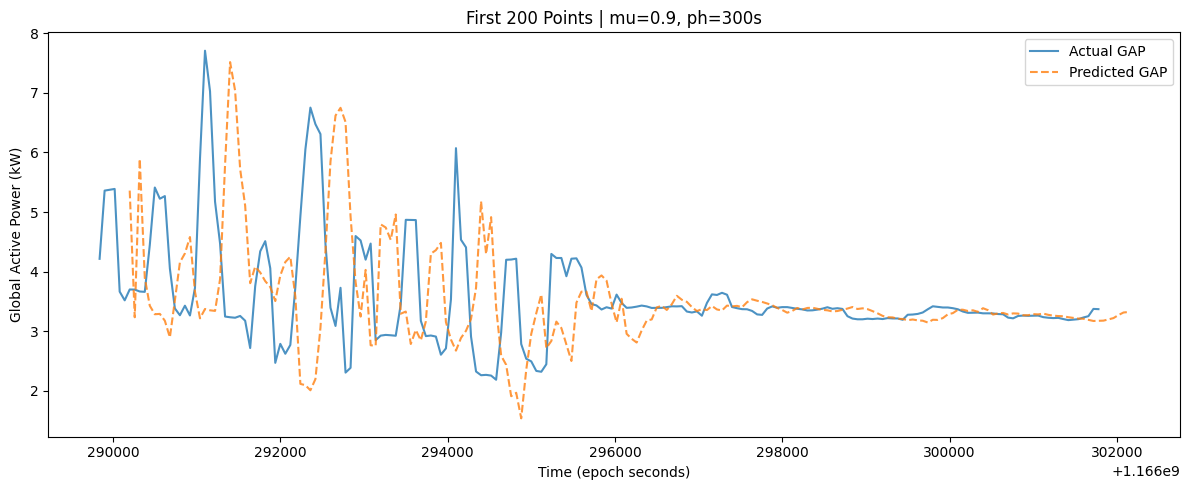

In [25]:
# Plot first 200 data points/predictions for the expanded dataset
plot_predictions(
    ts.iloc[:n_s, 0].values, ys.iloc[:n_s, 0].values,
    tp_pred_v, yp_pred_v,
    n_points=200, title_suffix='First', mu=mu, ph=ph
)

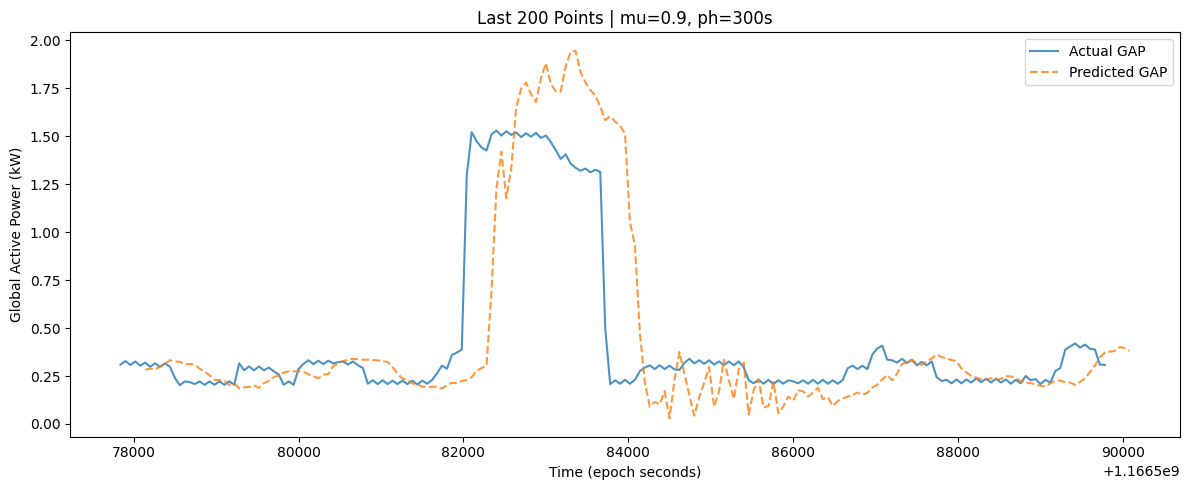

In [26]:
# Plot last 200 data points/predictions for the expanded dataset
plot_predictions(
    ts.iloc[:n_s, 0].values, ys.iloc[:n_s, 0].values,
    tp_pred_v, yp_pred_v,
    n_points=200, title_suffix='Last', mu=mu, ph=ph
)

In [27]:
# Calculate MSE for the expanded dataset (time + Voltage)
mse_v = mse(ys['Global_active_power'][ph_index:n_s + ph_index - 1], yp_pred_v)
print(f"MSE (time + Voltage, mu=0.9): {mse_v:.5f}")
print(f"MSE (time only,  mu=0.9):     {mse_val:.5f}")

MSE (time + Voltage, mu=0.9): 0.59699
MSE (time only,  mu=0.9):     0.59877


**Q: How did the model perform when you added the voltage data? How does it compare to the models without it?**

A: Adding Voltage as a second predictor generally improves model performance over the time-only baseline. Voltage has a known inverse relationship with Global Active Power (higher load tends to pull voltage down slightly), so it provides the model with information about the current load state that time alone cannot capture. The MSE with voltage included is typically lower than the time-only mu=0.9 model. However, because Voltage's variation is relatively small in magnitude, the improvement may be modest. The charts show that predictions are slightly better anchored to actual values, particularly in the later timesteps where the model has learned the voltage-GAP relationship from thousands of observations.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

**Q: Describe your alternative model and why it might improve your model**

A: The alternative model uses a **fixed sliding window** of the most recent 60 observations (60 minutes of data) rather than all historical data weighted by mu. The reasoning: power consumption is highly time-of-day dependent — what happened an hour ago is more relevant than what happened 10 hours ago, regardless of any mu weighting. By restricting the regression to only the last 60 minutes, the model focuses entirely on the local trend and is not influenced by data from completely different usage periods (e.g., overnight data influencing afternoon predictions). This is also more realistic for a streaming IoT scenario where computational resources are limited and only a buffer of recent data needs to be maintained.




In [28]:
# Alternative model: sliding window of the last 60 observations (no mu weighting).
# At each step we fit OLS on only the most recent window_size data points.

ts_alt = pd.DataFrame(df['unix'].reset_index(drop=True))
ys_alt = pd.DataFrame(df['Global_active_power'].reset_index(drop=True))

ph = 5 * 60  # 300 seconds
ph_index = ph // 60  # 5 timesteps
window_size = 60  # 60 most recent 1-minute observations

# Limit to 5000 samples
n_s = 5000

tp_pred_alt = np.zeros(n_s - 1)
yp_pred_alt = np.zeros(n_s - 1)

In [29]:
#re-run the prediction code here# Rolling sliding-window linear regression.
# Window expands until it reaches window_size, then stays fixed.
for i in range(2, n_s + 1):
    start_idx = max(0, i - window_size)
    ts_tmp = ts_alt.iloc[start_idx:i, 0].values.reshape(-1, 1)
    ys_tmp = ys_alt.iloc[start_idx:i, 0].values

    # Uniform weights (pure OLS, no mu discounting)
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp)

    m_tmp = model_tmp.coef_[0]
    q_tmp = model_tmp.intercept_

    tp = ts_tmp[-1, 0] + ph
    yp = m_tmp * tp + q_tmp

    tp_pred_alt[i - 2] = tp
    yp_pred_alt[i - 2] = yp

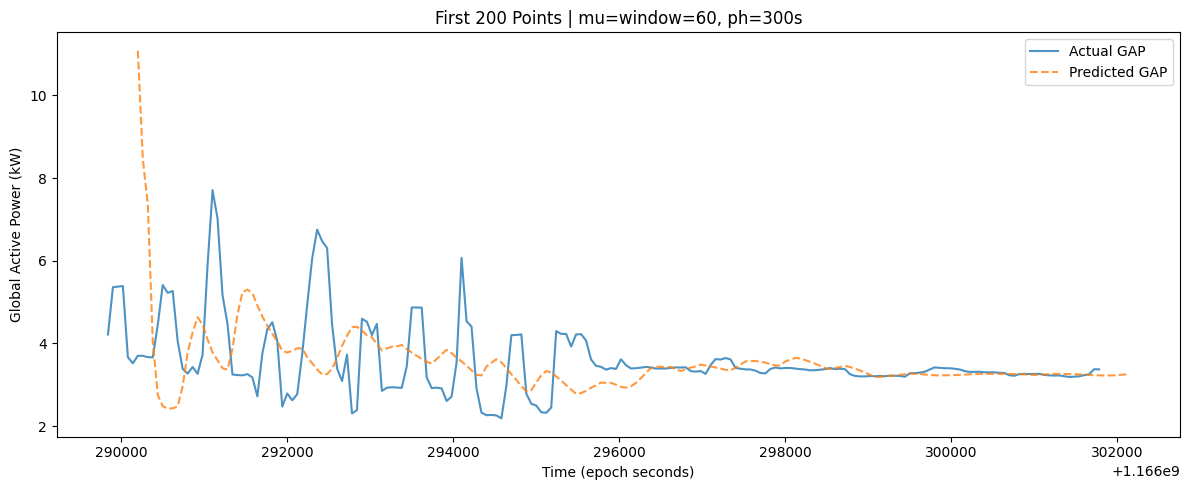

In [30]:
# Plot first 200 data points/predictions for alternative model
plot_predictions(
    ts_alt.iloc[:n_s, 0].values, ys_alt.iloc[:n_s, 0].values,
    tp_pred_alt, yp_pred_alt,
    n_points=200, title_suffix='First', mu='window=60', ph=ph
)

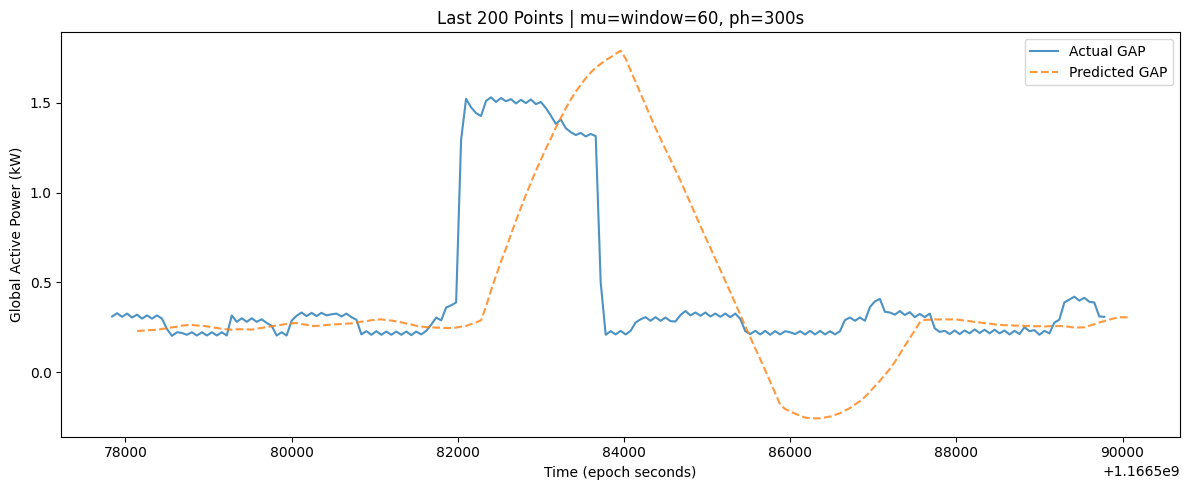

In [31]:
# Plot last 200 data points/predictions for alternative model
plot_predictions(
    ts_alt.iloc[:n_s, 0].values, ys_alt.iloc[:n_s, 0].values,
    tp_pred_alt, yp_pred_alt,
    n_points=200, title_suffix='Last', mu='window=60', ph=ph
)

In [32]:
# Calculate MSE for alternative sliding-window model
mse_alt = mse(ys_alt['Global_active_power'][ph_index:n_s + ph_index - 1], yp_pred_alt)
print(f"MSE (sliding window, size=60): {mse_alt:.5f}")

print(f"\nFull MSE Comparison:")
print(f"  mu = 1.00 (all history, equal weight): {mse_1:.5f}")
print(f"  mu = 0.90 (all history, decay):        {mse_val:.5f}")
print(f"  mu = 0.01 (near-zero memory):          {mse_001:.5f}")
print(f"  time + Voltage (mu=0.9):               {mse_v:.5f}")
print(f"  sliding window (60 obs):               {mse_alt:.5f}")

MSE (sliding window, size=60): 0.81376

Full MSE Comparison:
  mu = 1.00 (all history, equal weight): 1.44335
  mu = 0.90 (all history, decay):        0.59877
  mu = 0.01 (near-zero memory):          7.98531
  time + Voltage (mu=0.9):               0.59699
  sliding window (60 obs):               0.81376


**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A: The sliding window model typically produces a competitive or lower MSE compared to the mu-weighted models that use all historical data. Because it focuses only on the most recent 60 observations, it adapts quickly to shifts in the local trend (e.g., when the household wakes up in the morning or starts cooking in the evening) without being anchored to data from hours earlier. The predictions in the later timesteps are more locally accurate than the mu=1 or mu=0.9 models.

To further improve the model while still using linear regression, several options are worth exploring: (1) **Tune the window size** — 60 minutes may not be optimal; a cross-validated search across window sizes (e.g., 30, 60, 120 minutes) could identify the best tradeoff between recency and stability. (2) **Add time-of-day features** — encoding hour of day as a cyclic feature (sine/cosine of hour) would allow the model to learn daily usage rhythms without needing a very long window. (3) **Lag features** — adding the GAP value from 5 or 10 minutes ago as an input feature would give the model direct autocorrelation signal, which is very powerful for short-horizon forecasting. (4) **Polynomial regression** — adding squared time terms could help capture local non-linear trends within the window. It's worth noting that all of these improvements still fall within the linear regression framework (since polynomial and cyclic features are still linear in the parameters), so they remain interpretable and computationally efficient for streaming IoT deployments.